## Visualize ECCO volume budget from Ivana Cerovecki

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import so_decadal_variability.calc as socalc

In [3]:
# Load ecco
# This netcdf created from data provided by IC in load_ecco.py
# Original data here: 
# '/local/projects/so_decadal_variability/ECCOv4r4/binned_vol_budget_gamma/'
# The original data have been manipulated to return a value for WMT, by
# multiplying by rho0 (1024.5 for ecco) and dividing by \delta\gamma (0.1)
rootdir = '../'
localdir = 'data/processed/ECCO/'
filename = 'binned_vol_budget_month_dGamman_0.1.nc'
ecco = xr.open_dataset(rootdir+localdir+filename).drop('bin_vol')
terms = ecco.data_vars
signs = {'bin_ADV':1,'bin_DIF':1,'bin_FORC':1,'bin_TEN':-1}
names = {'bin_ADV':'$\psi$','bin_DIF':'$G_{int}$','bin_FORC':'$G_{surf}$','bin_TEN':'$dMdt$'}
# Remove obscure values in early years and late years
ecco=ecco.sel({'time':slice('1994-01-01','2016-12-31'),'gamma_n':slice(26.1,29)})

### Full balance

/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


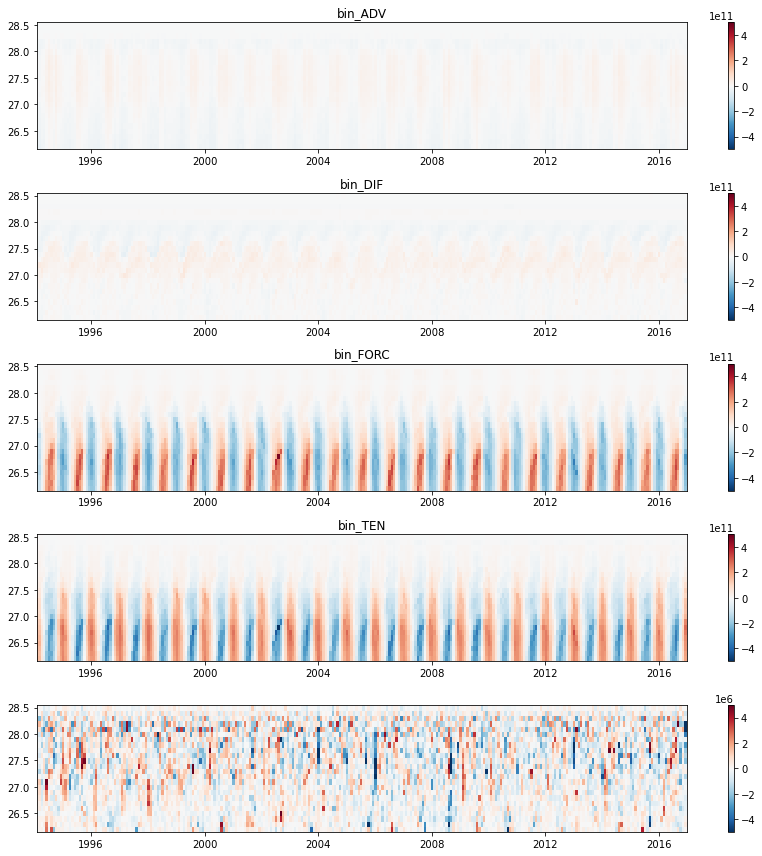

In [4]:
residual = xr.zeros_like(ecco['bin_ADV'])
clims = [-5E11, 5E11]
precision = 1E-5
fig,ax = plt.subplots(figsize = (12,12), nrows = len(ecco.data_vars)+1)
count = 0
for term in terms:
    sign=signs[term]
    axnow = ax[count]
    im = axnow.pcolormesh(ecco['time'],ecco['gamma_n'],
                          sign*ecco[term],
                          vmin=clims[0],vmax=clims[1],cmap='RdBu_r')
    axnow.set_title(term)
    plt.colorbar(im,ax=axnow)

    residual += sign*ecco[term]
    count+=1
        
im = ax[count].pcolormesh(residual['time'],residual['gamma_n'],
                          residual,
                          vmin=clims[0]*precision,vmax=clims[1]*precision,
                          cmap='RdBu_r')
plt.colorbar(im,ax=ax[count])

plt.tight_layout()

### Annual anomaly balance

/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: shading='fl

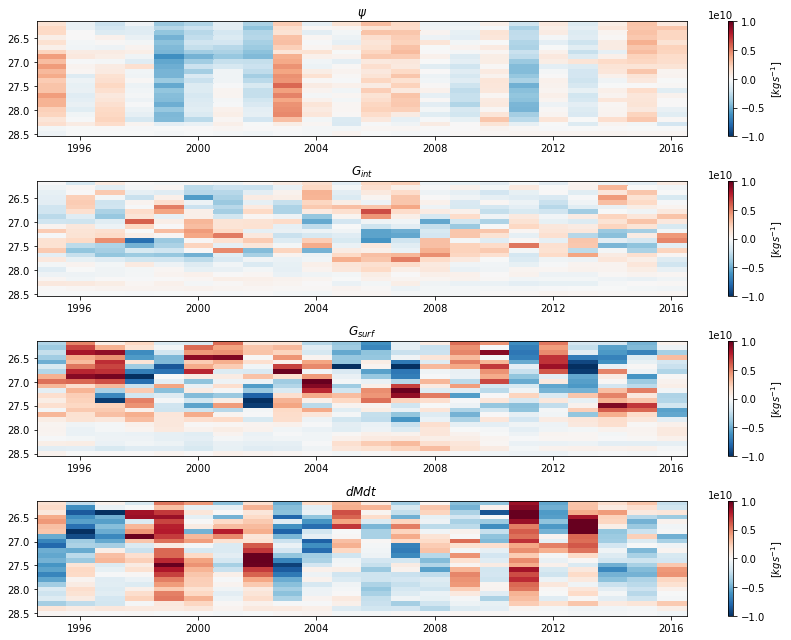

In [5]:
def calc_annualanom(da):
    annual = da.coarsen(time=12,boundary='trim').mean()
    mean = da.mean('time')*xr.ones_like(annual)
    annualanom = annual-mean
    return annualanom

ecco_annanom = xr.Dataset()

clims = [-1E10, 1E10]
fig,ax = plt.subplots(figsize = (12,9), nrows = len(ecco.data_vars))
count=0
for term in terms:
    sign=signs[term]
    ecco_annanom[term] = calc_annualanom(ecco[term])
    
    axnow = ax[count]
    im = axnow.pcolormesh(ecco_annanom[term]['time'],
                          ecco_annanom[term]['gamma_n'],
                          sign*ecco_annanom[term],
                          vmin=clims[0],vmax=clims[1],cmap='RdBu_r')
    axnow.set_title(names[term])
    axnow.invert_yaxis()
    cb = plt.colorbar(im,ax=axnow)
    cb.set_label('[$kgs^{-1}$]')

    count+=1
        
plt.tight_layout()

### Across a specific neutral surface

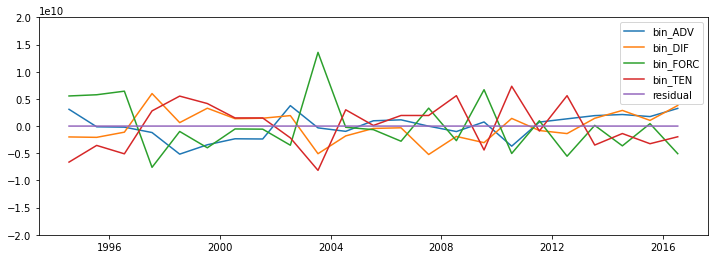

In [6]:
gammaT = 27
residual = xr.zeros_like(ecco_annanom['bin_ADV'].sel(gamma_n=gammaT,method='nearest'))
fig,ax = plt.subplots(figsize=(12,4))
for term in terms:
    sign=signs[term]
    value = sign*ecco_annanom[term].sel(gamma_n=gammaT,method='nearest')
    ax.plot(ecco_annanom['time'],value,label=term)

    residual += value
        
ax.plot(residual['time'],residual,label='residual')
ax.set_ylim([-2E10, 2E10])
ax.legend()

### Time-mean picture

Text(0, 0.5, 'Mass transport [$kgs^{-1}$]')

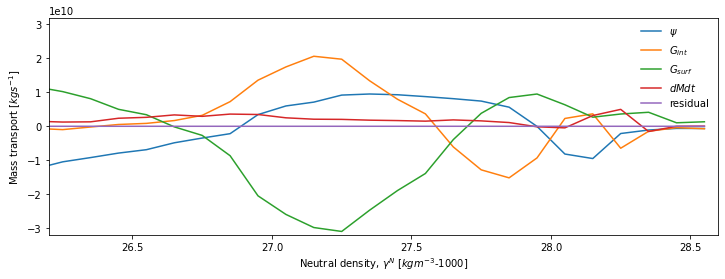

In [7]:
# Transformation
residual = xr.zeros_like(ecco['bin_ADV'].mean('time'))
fig,ax = plt.subplots(figsize=(12,4))
for term in terms:
    sign=signs[term]
    value = sign*ecco[term].mean('time')
    ax.plot(ecco['gamma_n'],value,label=names[term])
    residual += value
        
ax.plot(residual['gamma_n'],residual,label='residual')
ax.set_xlim([26.2, 28.6])
ax.set_ylim([-3.2E10, 3.2E10])
ax.legend(frameon=False)
ax.set_xlabel('Neutral density, $\gamma^N$ [$kgm^{-3}$-1000]')
ax.set_ylabel('Mass transport [$kgs^{-1}$]')

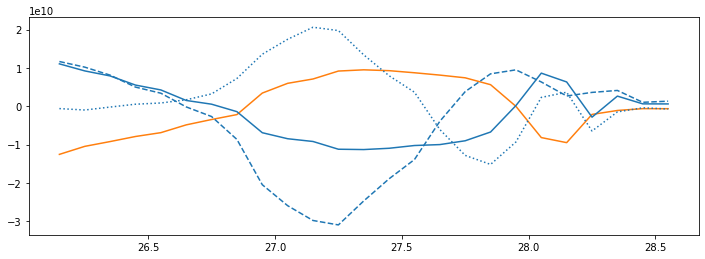

In [8]:
# Transformation
residual = xr.zeros_like(ecco['bin_ADV'].mean('time'))
fig,ax = plt.subplots(figsize=(12,4))
term='bin_ADV'
sign=signs[term]
value = sign*ecco[term].mean('time')
ax.plot(ecco['gamma_n'],value,label=names[term],color='tab:orange')

term='bin_FORC'
sign=signs[term]
value = sign*ecco[term].mean('time')
ax.plot(ecco['gamma_n'],value,label=names[term],color='tab:blue',linestyle='--')

term='bin_DIF'
sign=signs[term]
value = sign*ecco[term].mean('time')
ax.plot(ecco['gamma_n'],value,label=names[term],color='tab:blue',linestyle=':')

value = (ecco['bin_FORC']+ecco['bin_DIF']).mean('time')
ax.plot(ecco['gamma_n'],value,label=names[term])

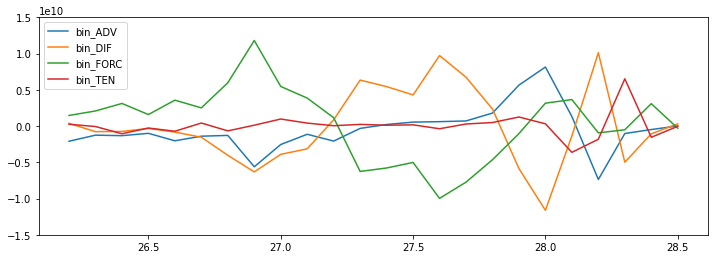

In [9]:
# Formation
fig,ax = plt.subplots(figsize=(12,4))
for term in terms:
    sign=signs[term]
    value = -1*sign*ecco[term].diff('gamma_n').mean('time')
    x = 0.5*(ecco['gamma_n'][1:].values+ecco['gamma_n'][:-1].values)
    ax.plot(x,value,label=term)
    
ax.set_ylim([-1.5E10, 1.5E10])
ax.legend()

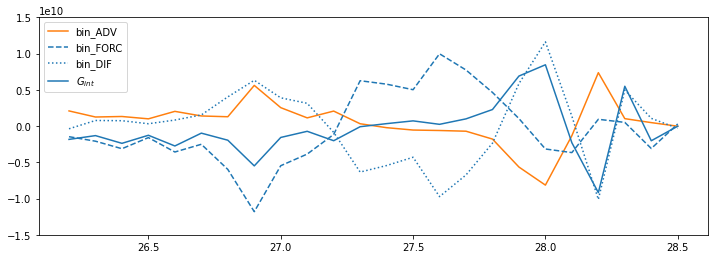

In [21]:
# Formation
fig,ax = plt.subplots(figsize=(12,4))

x = 0.5*(ecco['gamma_n'][1:].values+ecco['gamma_n'][:-1].values)

term='bin_ADV'
sign=signs[term]
value = sign*ecco[term].diff('gamma_n').mean('time')
ax.plot(x,value,label=term, color='tab:orange')

term='bin_FORC'
sign=signs[term]
value = sign*ecco[term].diff('gamma_n').mean('time')
ax.plot(x,value,label=term, color='tab:blue', linestyle='--')

term='bin_DIF'
sign=signs[term]
value = sign*ecco[term].diff('gamma_n').mean('time')
ax.plot(x,value,label=term, color='tab:blue', linestyle=':')

value = (ecco['bin_FORC']+ecco['bin_DIF'])
value = value.diff('gamma_n').mean('time')
ax.plot(x,value,label=names[term])
    
ax.set_ylim([-1.5E10, 1.5E10])
ax.legend()

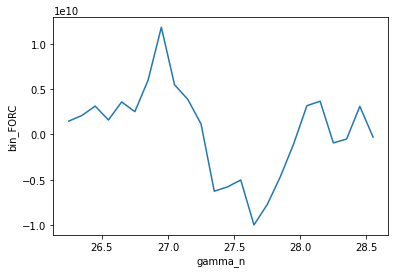

In [11]:
(-1*sign*ecco['bin_FORC'].diff('gamma_n').mean('time')).plot()

### Annual anomalies

Text(0, 0.5, 'Formation rate [$kgs^{-1}$]')

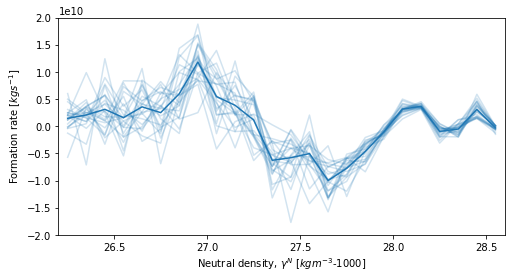

In [12]:
term = 'bin_FORC'
fig,ax=plt.subplots(figsize=(8,4))
div = -1*ecco[term].diff('gamma_n')
ax.plot(div['gamma_n'],socalc._annual(div),color='tab:blue',alpha=0.2)
ax.plot(div['gamma_n'],div.mean('time'),color='tab:blue')
ax.set_ylim([-2E10, 2E10])
ax.set_xlim([26.2,28.6])
ax.set_xlabel('Neutral density, $\gamma^N$ [$kgm^{-3}$-1000]')
ax.set_ylabel('Formation rate [$kgs^{-1}$]')

Text(0, 0.5, 'Formation rate [$kgs^{-1}$]')

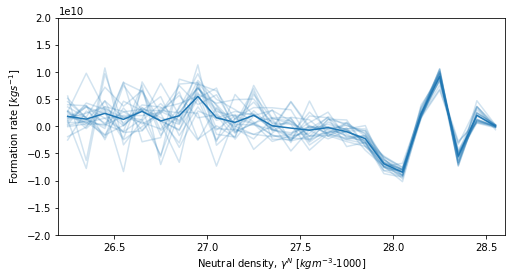

In [13]:
fig,ax=plt.subplots(figsize=(8,4))
div = -1*(ecco['bin_FORC']+ecco['bin_DIF']).diff('gamma_n')
ax.plot(div['gamma_n'],socalc._annual(div),color='tab:blue',alpha=0.2)
ax.plot(div['gamma_n'],div.mean('time'),color='tab:blue')
ax.set_ylim([-2E10, 2E10])
ax.set_xlim([26.2,28.6])
ax.set_xlabel('Neutral density, $\gamma^N$ [$kgm^{-3}$-1000]')
ax.set_ylabel('Formation rate [$kgs^{-1}$]')

### Does tendency + forcing = advection ?

/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys
/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if sys.path[0] == '':


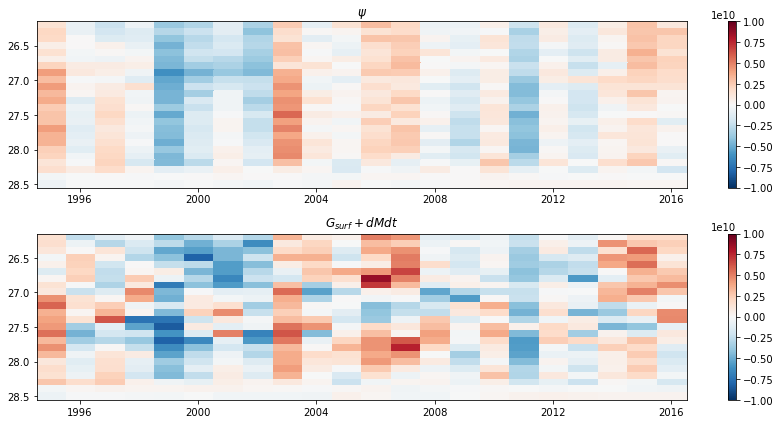

In [14]:
ADV = signs['bin_ADV']*ecco_annanom['bin_ADV']
ADV_est = -1*(signs['bin_FORC']*ecco_annanom['bin_FORC']+signs['bin_TEN']*ecco_annanom['bin_TEN'])

clims = [-1E10, 1E10]
fig,ax = plt.subplots(figsize=(12,6),nrows=2)
im = ax[0].pcolormesh(ADV['time'],ADV['gamma_n'],ADV,
                 cmap='RdBu_r',vmin=clims[0],vmax=clims[1])
ax[0].set_title('$\psi$')
ax[0].invert_yaxis()
plt.colorbar(im,ax=ax[0])
im = ax[1].pcolormesh(ADV_est['time'],ADV_est['gamma_n'],ADV_est,
                 cmap='RdBu_r',vmin=clims[0],vmax=clims[1])
ax[1].set_title('$G_{surf} + dMdt$')
ax[1].invert_yaxis()
plt.colorbar(im,ax=ax[1])
plt.tight_layout()

### Formation and upwelling

/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]
/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]
/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/ipykernel_launcher.py:13: Matpl

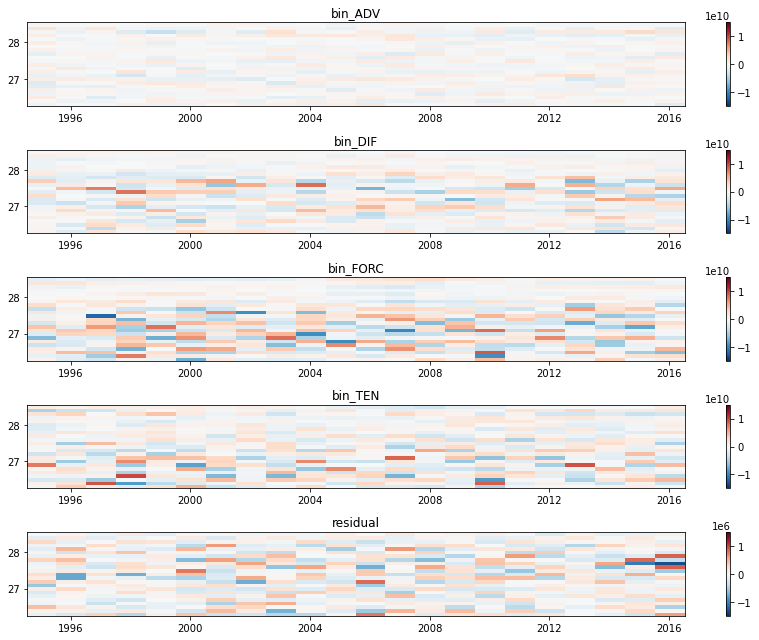

In [15]:
clims = [-1.5E10, 1.5E10]
residual = xr.zeros_like(socalc._annualanom(ecco['bin_FORC'].diff('gamma_n')))
fig,ax = plt.subplots(figsize = (12,9), nrows = len(ecco.data_vars)+1)
count=0
for term in terms:
    sign=signs[term]
    
    value = socalc._annualanom(-1*ecco[term].diff('gamma_n'))
    axnow = ax[count]
    im = axnow.pcolormesh(value['time'],
                          value['gamma_n'],
                          sign*value,
                          vmin=clims[0],vmax=clims[1],cmap='RdBu_r')
    axnow.set_title(term)
    plt.colorbar(im,ax=axnow)
    
    residual+=sign*value
    count+=1

im = ax[count].pcolormesh(residual['time'],
                          residual['gamma_n'],
                          residual,
                          vmin=clims[0]*1E-4,vmax=clims[1]*1E-4,cmap='RdBu_r')
ax[count].set_title('residual')
plt.colorbar(im,ax=ax[count])
plt.tight_layout()

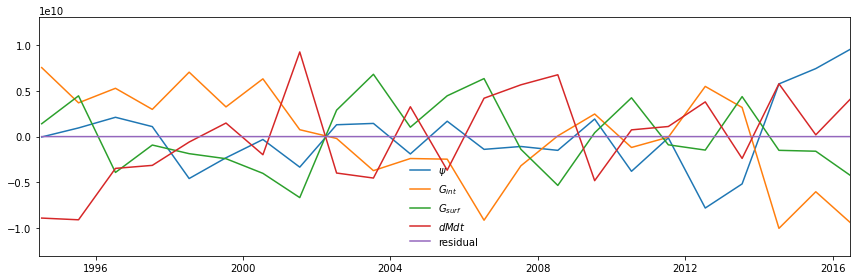

In [122]:
# Upwelling
clims = [-1.5E10, 1.5E10]
residual = xr.zeros_like(socalc._annualanom(ecco['bin_FORC'].diff('gamma_n')).sum('gamma_n'))
condition = (socalc._annual(-1*ecco['bin_FORC'].diff('gamma_n'))<0)
fig,ax = plt.subplots(figsize = (12,4))
count=0
for term in terms:
    sign=signs[term]
    
    div = socalc._annual(-1*ecco[term].diff('gamma_n'))
    upwelling = div.where(condition,0).sel(gamma_n=slice(26.9,9999)).sum('gamma_n')
    upwelling_anom = upwelling-upwelling.mean('time')
    axnow = ax
    im = axnow.plot(upwelling_anom['time'],
                          sign*upwelling_anom,label=names[term])
    
    residual+=sign*upwelling_anom
    count+=1

im = ax.plot(residual['time'],
                          residual,label='residual')
ax.set_xlim('1994-06-15','2016-06-15')
ax.set_ylim(-1.3E10,1.3E10)
ax.legend(frameon=False)
plt.tight_layout()

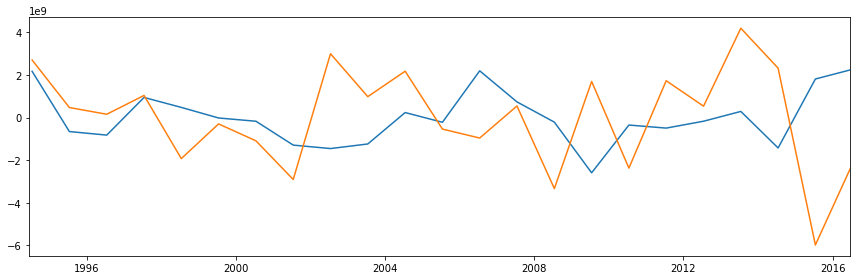

In [20]:
# Upwelling
clims = [-1.5E10, 1.5E10]
residual = xr.zeros_like(socalc._annualanom((ecco['bin_FORC']+ecco['bin_DIF']).diff('gamma_n')).sum('gamma_n'))
condition = (socalc._annual(-1*(ecco['bin_FORC']+ecco['bin_DIF']).diff('gamma_n'))<0)
fig,ax = plt.subplots(figsize = (12,4))

term = 'bin_ADV'
div = socalc._annual(-1*ecco[term].diff('gamma_n'))
upwelling = div.where(condition,0).sel(gamma_n=slice(27.75,28.25)).sum('gamma_n')
upwelling_anom = upwelling-upwelling.mean('time')
axnow = ax
im = axnow.plot(upwelling_anom['time'],upwelling_anom,label=names[term])

div = socalc._annual(-1*(ecco['bin_FORC']+ecco['bin_DIF']).diff('gamma_n'))
upwelling = div.where(condition,0).sel(gamma_n=slice(27.75,28.25)).sum('gamma_n')
upwelling_anom = upwelling-upwelling.mean('time')
axnow = ax
im = axnow.plot(upwelling_anom['time'],upwelling_anom,label=names[term])


ax.set_xlim('1994-06-15','2016-06-15')
# ax.set_ylim(-1.3E10,1.3E10)
# ax.legend(frameon=False)
plt.tight_layout()